# Solving Ordinary Differential Equations in Jupyter

It is sometimes useful, if not coerced, to solve differential equations numerically rather than analytically. Jupyter is an excellent tool for solving differential equations, since the notebook platform can allow the user to apply the algorithm, print and visualize solutions, and report conclusions in a single document. 

One common nonlinear differential equation in physics is simple harmonic motion of a simple pendulum, which is governed by the ODE 

$$ \ddot \phi = -\frac{g}{L}\sin\phi .$$

In this notebook, I demonstrate how to solve ODEs in Python/Jupyter, using the harmonic oscillator as an example. 

## Derivation and Analytical Solution

Suppose a pendulum of length $L = 5.0$ m is dropped from rest at an angle 10 degrees from the vertical. At any point in its motion, the kinetic energy of the bob is $T = \frac{1}{2}mL^2\dot \phi^2$ and its gravitational potential energy is $V = -mgL\cos\phi$, where $y=0$ at the pivot point. The Euler-Lagrange equation states that
$$ \frac{\partial \mathcal L}{\partial \phi} - \frac{d}{dt} \frac{\partial \mathcal L}{\partial \dot\phi} = 0,$$
where $\mathcal{L} = T-V$. Solving this equation immediately yields
$$mgL\sin\phi = \frac{d}{dt}\left( mL^2\dot\phi \right), $$
which simplifies to the commonly-known second-order, nonlinear, differential equation:
$$ \ddot \phi = -\frac{g}{L}\sin\phi. $$
As it stands, this equation has no true analytical solution. However, we can solve for $\phi(t)$ if we assume that oscillations are small, i.e. $\sin\phi = \phi$. In that case, we get the DE
$$\ddot \phi = -\frac{g}{L}\phi.$$
This is solvable using the auxiliary equation method, which results in two, distinct, complex roots $\pm i\sqrt{\frac{g}{L}}$. Therefore, the equation of motion is
$$ \phi(t) = A\sin(\omega t) + B\cos(\omega t),$$
where $ \omega = \sqrt{\frac{g}{L}}$. Since the pendulum starts at $\pi/18$ at $t=0$, we can say that $B = \pi/18$. Also, because the pendulum is relased from rest, $A = 0$. Therefore, the unique equation of motion is
$$\phi(t) = \frac{\pi}{18}\cos(\omega t). $$
In the cell below, we plot this solution.

<IPython.core.display.Javascript object>


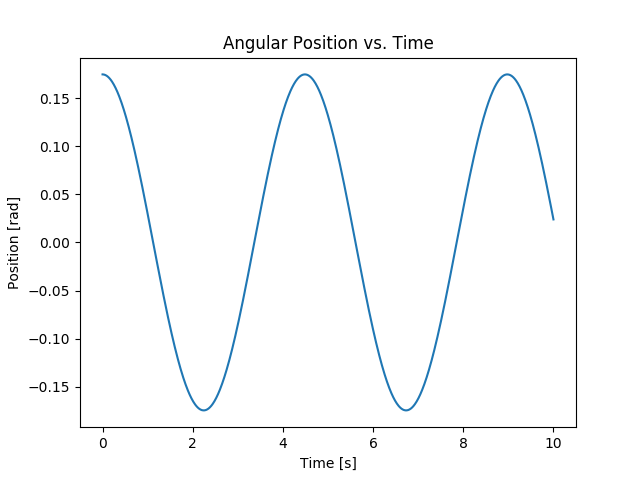

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

time = np.linspace(0,10,1000)

def analyt_sol(L, t):
    omega = np.sqrt(9.8/L)
    return (np.pi/18.0)*np.cos(omega*t)

def analyt_sol_vphi(L, t):
    omega = np.sqrt(9.8/L)
    return -1*(np.pi/18.0)*omega*np.sin(omega*t)

phi = analyt_sol(5, time)
vphi = analyt_sol_vphi(5, time)

plt.plot(time, phi, label="Angular Position")
plt.title("Angular Position vs. Time")
plt.xlabel("Time [s]")
plt.ylabel("Position [rad]")
plt.show()

## Numerical Solution 

In this section of the notebook, we solve the original differential equation in multiple ways, including the Euler method and the Heun method.

### Euler Method

In the cell below, I construct an algorithm for performing the Euler method in Python. This algorithm is then used to solve the second-order ODE described above.

Now that we have produced the data, we can plot the solution to our ODE, which is shown in the next figure. It is clear that the residuals vary with a single oscillation, though the amplitude of this mode exponentionally increases over time. This suggests that the energy of the system is also increasing, which means that the Euler method does not conserve energy, since no external forces are doing work on the system.

In [3]:
# Define a function to do the Euler method
def predict(old, slope, interval):
    return old + slope*interval

# Define function to calculate slope of velocity

def f(g,R,phi):
    return -(g/R) * np.sin(phi)

# Function to calculate analytic solution to the small angle approximation

def phi_analytic(g,R,phi0,vphi0,t):
    A = phi0
    B = np.sqrt(R/g)*vphi0
    omega = np.sqrt(g/R)
    return A*np.cos(omega*t) + B*np.sin(omega*t)

# Define paramaters

g = 9.8
R = 5.0
t = 0
dt = 0.05
tmax = 10
i = 0

# Define initial values of variables

vphi_old = 0
phi_old = np.pi/18.0

# Initialize arrays to hold values of variables; assume we need 1000 elements

time = np.zeros(int(tmax/dt)+1)
phi = np.zeros(int(tmax/dt)+1)
vphi = np.zeros(int(tmax/dt)+1)

while t < tmax:
    # Store current variable values in arrays
    time[i] = t
    phi[i] = phi_old
    vphi[i] = vphi_old

    # Predict new values using old values
    vphi_new = predict(vphi_old, f(g,R,phi_old), dt)
    phi_new = predict(phi_old, vphi_old, dt)

    # Store new values for next iteration
    vphi_old = vphi_new
    phi_old = phi_new

    # Update time and counter

    t+=dt
    i+=1




<IPython.core.display.Javascript object>


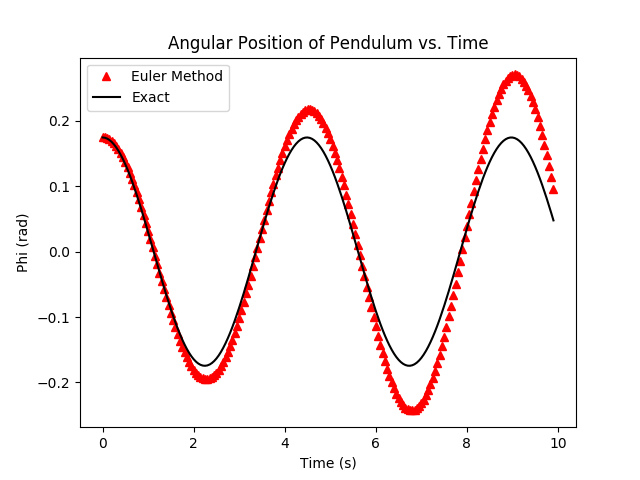

In [4]:
# Plot the angle of the skateboard
plt.plot(time[0:i-1], phi[0:i-1], 'r^', label='Euler Method')
plt.plot(time[0:i-1], phi_analytic(g,R,phi[0],vphi[0], time[0:i-1]), 'k', label='Exact')
plt.title('Angular Position of Pendulum vs. Time')
plt.xlabel("Time (s)")
plt.ylabel("Phi (rad)")
plt.legend(loc="best")

### Heun's Method (Improved Euler Method)

Heun's method is the same as the Euler method, but it makes a correction to the predicted y-value by considering the slope of the tanget line at both sides of integration element. In this section, we re-perform the computation and compare the results to the Euler method.

In [9]:
# Define paramaters

g = 9.8 
R = 5.0
t = 0
dt = 0.05
tmax = 10
i = 0

# Define initial values of variables

vphi_old = 0
phi_old = np.pi/18.0

# Initialize arrays to hold values of variables; assume we need 1000 elements

time = np.zeros(int(tmax/dt)+1)
phi = np.zeros(int(tmax/dt)+1)
vphi = np.zeros(int(tmax/dt)+1)

while t < tmax:
    # Store current variable values in arrays
    time[i] = t
    phi[i] = phi_old
    vphi[i] = vphi_old 

    # Predict new values using old values
    vphi_new = predict(vphi_old, f(g,R,phi_old), dt)
    phi_new = predict(phi_old, vphi_old, dt)

    # Correct predicted values for the variables using an average
    phi_cor = predict(phi_old, 0.5*(vphi_old + vphi_new), dt)
    vphi_cor = predict(vphi_old, 0.5*(f(g,R,phi_old) + f(g,R,phi_new)), dt)

    # Store new values for next iteration
    vphi_old = vphi_cor
    phi_old = phi_cor

    # Update time and counter
    
    t+=dt
    i+=1

The figure below shows the Heun-method approximation of the pendulum equation. This technique clearly does a better job at conserving energy, as evident by the lower residuals, especially near the local extrema.

<IPython.core.display.Javascript object>


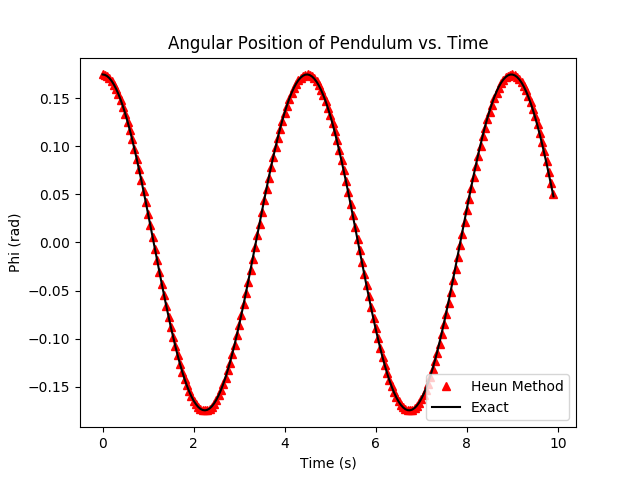

-0.163713542024
0.174571249643


In [10]:
# Plot the angle of the skateboard

plt.plot(time[0:i-1], phi[0:i-1], 'r^', label='Heun Method')
plt.plot(time[0:i-1], phi_analytic(g,R,phi[0],vphi[0], time[0:i-1]), 'k', label='Exact')
plt.title('Angular Position of Pendulum vs. Time')
plt.xlabel("Time (s)")
plt.ylabel("Phi (rad)")
plt.legend(loc="best")
plt.show()

# t=2.5=T at i=50, 2T at i=90

print(phi[50])
print(phi[90])

### Fourth-Order Runge-Kutta Method

In this section, we solve the ODE using the Fourth-Order Runge-Kutta method. SciPy has a native method specifically for this computational technique. However, to use this function, we must first separate our second-order differential equation into two coupled, first order equations. This can be done simply as

$$ \omega = \frac{d\phi}{dt} $$
and
$$ \dot \omega = -\frac{g}{L}\sin\phi. $$

This allows us to solve the two first-order equations simultaneously using the SciPy routine.

In [11]:
# First, let's define a "pendulum" function.

def pendulum(y, t):
    g = 9.8 # m/s**2
    L = 5.0 #m
    phi, omega = y
    dydt = [omega, -(g/L)*np.sin(phi)]
    return dydt

# Make our initial conditions

theta0 = np.pi/18.0
omega0 = 0
y0 = [theta0, omega0]

# Make a linspace to hold time-values

time_rk4 = np.linspace(0,10,200)

# Integrate the solution
from scipy.integrate import odeint

sol_rk4 = odeint(pendulum, y0, time_rk4)

# Unpack the solution tuple
phi_rk4 = sol_rk4[:,0]
vphi_rk4 = sol_rk4[:,1]

The figure below shows the solution to $\ddot phi = -\frac{g}{L}\sin\phi$ using the Fourth-Order Runge-Kutta method. While the RK4 method is generally considered to be a superior computational technique, it offers no significant advantages for this ODE over Heun's method, which far less computationally-expensive.

<IPython.core.display.Javascript object>


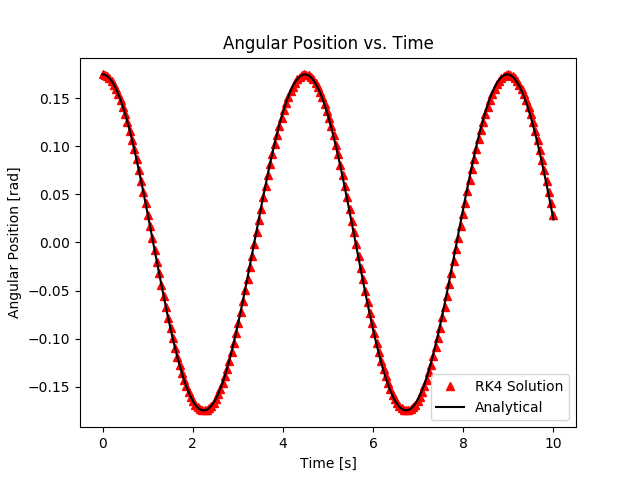

In [12]:
time = np.linspace(0,10,1000)
phi = analyt_sol(5.0, time)

plt.plot(time_rk4, phi_rk4, "r^", label="RK4 Solution")
plt.plot(time, phi, 'k', label="Analytical")
plt.title("Angular Position vs. Time")
plt.xlabel("Time [s]")
plt.ylabel("Angular Position [rad]")
plt.legend(loc="best")
plt.show()